# Tensorflow RNN Music Generator

In [58]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [59]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000

In [60]:
data_dir = pathlib.Path.cwd().joinpath("mids")
filenames = glob.glob(str(data_dir.joinpath("*.mid")))
print(len(filenames))

308


In [61]:
sample_file = filenames[1]
print(sample_file)

/workspaces/tf-jazz-generator/mids/127.mid


In [62]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [63]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds * _SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [64]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'
fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'
fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [65]:
print("Number of instruments:", len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print("Instrument name:", instrument_name)

Number of instruments: 3
Instrument name: Acoustic Grand Piano


In [66]:
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"{i}: pitch={note.pitch}, note_name={note_name},"
          f" duration={duration:.4f}")

0: pitch=60, note_name=C4, duration=0.1160
1: pitch=84, note_name=C6, duration=0.1120
2: pitch=80, note_name=G#5, duration=0.0960
3: pitch=77, note_name=F5, duration=0.1120
4: pitch=73, note_name=C#5, duration=0.1040
5: pitch=53, note_name=F3, duration=0.1520
6: pitch=49, note_name=C#3, duration=0.1280
7: pitch=53, note_name=F3, duration=0.5000
8: pitch=60, note_name=C4, duration=0.5280
9: pitch=63, note_name=D#4, duration=0.5640


In [67]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes["pitch"].append(note.pitch)
        notes["start"].append(start)
        notes["end"].append(end)
        notes["step"].append(start - prev_start)
        notes["duration"].append(end - start)
        prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [68]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,60,1.272,1.388,0.000,0.116
1,84,1.284,1.396,0.012,0.112
2,80,1.448,1.544,0.164,0.096
3,77,1.588,1.700,0.140,0.112
4,53,1.700,1.852,0.112,0.152


In [69]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes["pitch"])
sample_note_names[:10]

array(['C4', 'C6', 'G#5', 'F5', 'F3', 'C#5', 'C5', 'C#3', 'D#4', 'C4'],
      dtype='<U3')

In [70]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f"First {count} notes"
    else:
        title = f"Whole track"
        count = len(notes["pitch"])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes["pitch"], notes["pitch"]], axis=0)
    plot_start_stop = np.stack([notes["start"], notes["end"]], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel("Time [s]")
    plt.ylabel("Pitch")
    _ = plt.title(title)

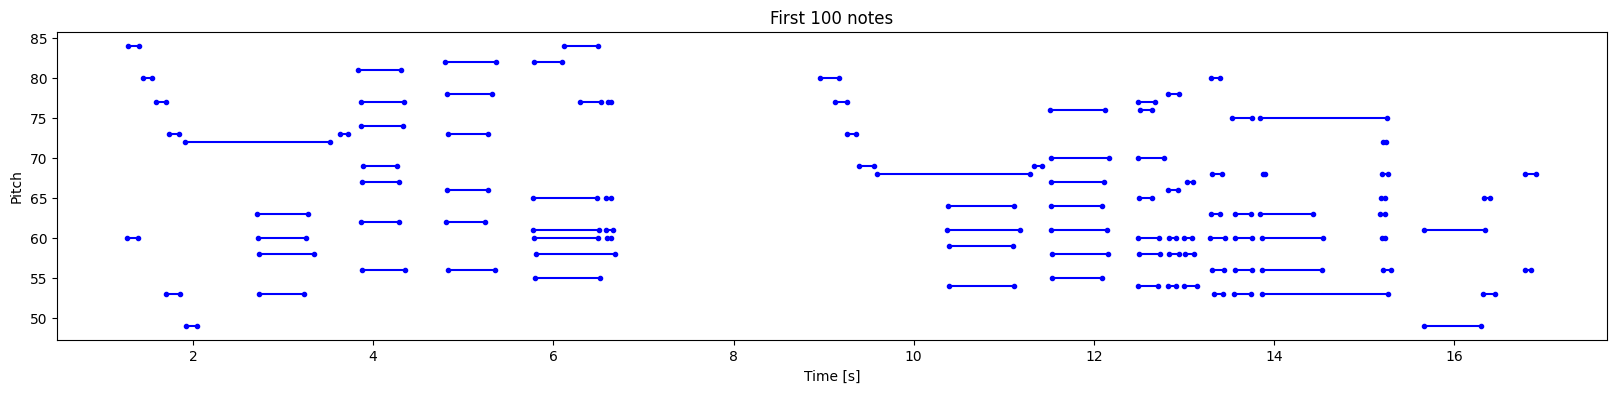

In [71]:
plot_piano_roll(raw_notes, count=100)

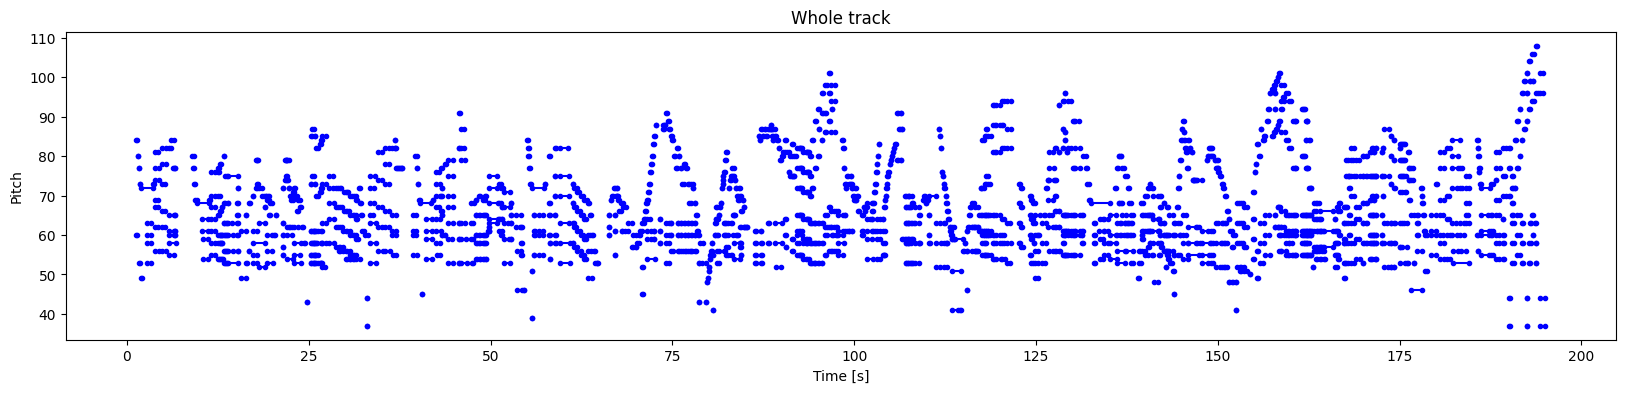

In [72]:
plot_piano_roll(raw_notes)

In [73]:
def plot_distribution(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)
    
    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes["step"], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
    
    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes["duration"], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

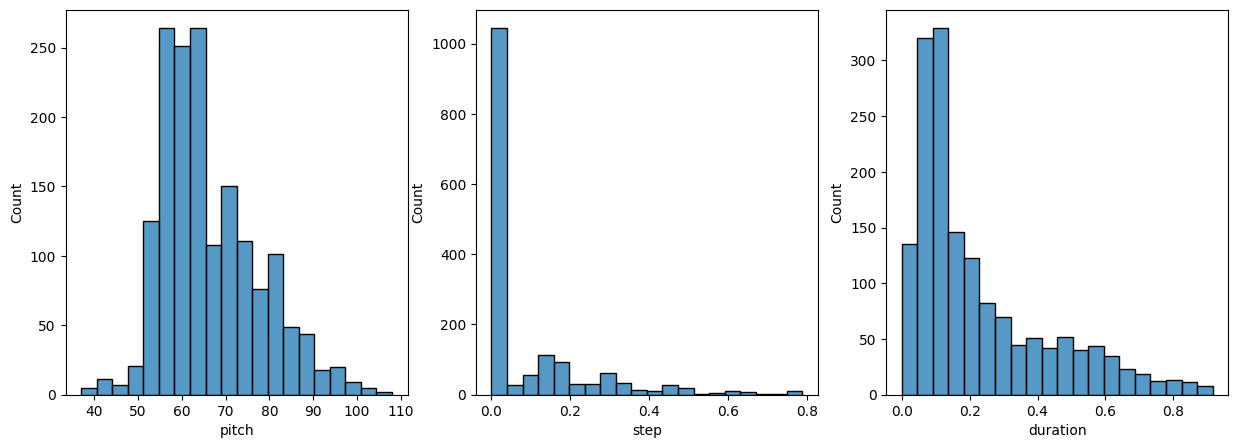

In [74]:
plot_distribution(raw_notes)

In [75]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int = 100,) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note["step"])
        end = float(start + note["duration"])
        note = pretty_midi.Note(velocity=velocity, pitch=int(note["pitch"]), start=start, end=end)
        instrument.notes.append(note)
        prev_start = start
    
    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [76]:
example_file = "example.mid"
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

In [77]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [78]:
num_files = 100
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [79]:
n_notes = len(all_notes)
print("Number of notes parsed:", n_notes)

Number of notes parsed: 180587


In [80]:
key_order = ["pitch", "step", "duration"]
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [81]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [82]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128,) -> tf.data.Dataset:
    seq_length = seq_length + 1
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)
    
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x
    
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i, key in enumerate(key_order)}
        return scale_pitch(inputs), labels
    
    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [83]:
seq_length = 150
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(150, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [84]:
for seq, target in seq_ds.take(1):
    print("sequence shape:", seq.shape)
    print("sequence elements (first 10):", seq[0: 10])
    print()
    print("target:", target)

sequence shape: (150, 3)
sequence elements (first 10): tf.Tensor(
[[0.4609375  0.         0.0714285 ]
 [0.28125    0.0428571  0.0285714 ]
 [0.4609375  0.36428535 0.06428565]
 [0.28125    0.28214258 0.0285714 ]
 [0.4609375  0.06071423 0.0714285 ]
 [0.4609375  0.11785702 0.07857135]
 [0.4609375  0.3999996  0.15357128]
 [0.296875   0.7285707  0.03571425]
 [0.4609375  0.00714285 0.06785708]
 [0.296875   0.14999985 0.04999995]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=59.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.01071427500000155>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.05357137500000064>}


In [85]:
batch_size = 64
buffer_size = n_notes - seq_length
train_ds = (seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [86]:
train_ds.element_spec

(TensorSpec(shape=(64, 150, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [87]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [88]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    "pitch": tf.keras.layers.Dense(128, name="pitch")(x),
    "step": tf.keras.layers.Dense(1, name="step")(x),
    "duration": tf.keras.layers.Dense(1, name="duration")(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    "pitch": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "step": mse_with_positive_pressure,
    "duration": mse_with_positive_pressure
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 3)]             0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  67584     ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_1[0][0]']              
                                                                                            

In [89]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2024-02-15 19:20:18.957605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16296: Filling up shuffle buffer (this may take a while): 49678 of 180437
2024-02-15 19:20:28.954555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16296: Filling up shuffle buffer (this may take a while): 97734 of 180437
2024-02-15 19:20:38.954715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16296: Filling up shuffle buffer (this may take a while): 145336 of 180437


      3/Unknown - 39s 44ms/step - loss: 5.3143 - duration_loss: 0.1949 - pitch_loss: 4.8500 - step_loss: 0.2695

2024-02-15 19:20:46.777041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


2819/2819 [==============================] - 175s 48ms/step - loss: 5.3872 - duration_loss: 0.2481 - pitch_loss: 4.8533 - step_loss: 0.2858


{'loss': 5.387189865112305,
 'duration_loss': 0.24813807010650635,
 'pitch_loss': 4.853259563446045,
 'step_loss': 0.28579002618789673}

In [90]:
model.compile(loss=loss, loss_weights={"pitch": 0.05, "step": 1.0, "duration": 1.0,}, optimizer=optimizer)

In [91]:
model.evaluate(train_ds, return_dict=True)

2819/2819 [==============================] - 135s 48ms/step - loss: 0.7766 - duration_loss: 0.2481 - pitch_loss: 4.8533 - step_loss: 0.2858


{'loss': 0.7765902876853943,
 'duration_loss': 0.24813807010650635,
 'pitch_loss': 4.853259563446045,
 'step_loss': 0.28579002618789673}

In [92]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="./training_checkpoints/ckpt_{epoch}", save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, verbose=1, restore_best_weights=True),
]

In [93]:
%%time
epochs = 50

history = model.fit(train_ds, epochs=epochs, callbacks=callbacks,)

Epoch 1/50


2819/2819 [==============================] - 345s 122ms/step - loss: 0.3562 - duration_loss: 0.1050 - pitch_loss: 3.7808 - step_loss: 0.0621
Epoch 2/50
2819/2819 [==============================] - 348s 123ms/step - loss: 0.3397 - duration_loss: 0.1014 - pitch_loss: 3.6252 - step_loss: 0.0571
Epoch 3/50
2819/2819 [==============================] - 346s 123ms/step - loss: 0.4703 - duration_loss: 0.1561 - pitch_loss: 4.4113 - step_loss: 0.0936
Epoch 4/50
2819/2819 [==============================] - 339s 120ms/step - loss: 0.4400 - duration_loss: 0.1511 - pitch_loss: 3.9815 - step_loss: 0.0898
Epoch 5/50
2819/2819 [==============================] - 337s 119ms/step - loss: 0.4161 - duration_loss: 0.1148 - pitch_loss: 3.9594 - step_loss: 0.1033
Epoch 6/50
2819/2819 [==============================] - 341s 121ms/step - loss: 0.4293 - duration_loss: 0.1329 - pitch_loss: 3.9318 - step_loss: 0.0998
Epoch 7/50
2819/2819 [==============================] - 341s 121ms/step - loss: 0.4246 - duration_l

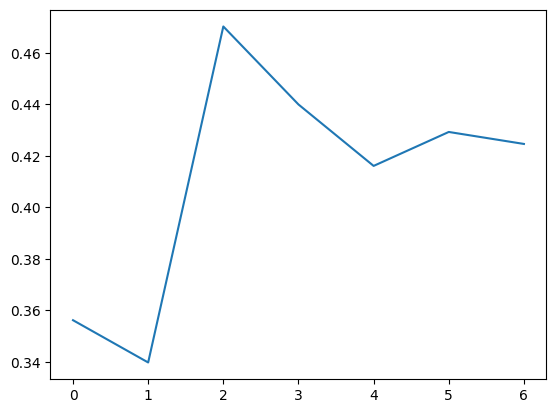

In [94]:
plt.plot(history.epoch, history.history["loss"], label="total loss")
plt.show()

In [95]:
def predict_next_note(notes: np.ndarray, model: tf.keras.Model, temperature: float = 1.0) -> tuple[int, float, float]:
    assert temperature > 0
    
    inputs = tf.expand_dims(notes, 0)
    
    predictions = model.predict(inputs)
    pitch_logits = predictions["pitch"]
    step = predictions["step"]
    duration = predictions["duration"]
    
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)
    
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)
    
    return int(pitch), float(step), float(duration)

In [96]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, "start", "end"))

1/1 [==============================] - 0s 26ms/step


In [97]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,63,0.394976,0.450519,0.394976,0.845495
1,96,0.266310,0.000000,0.661286,0.661286
2,98,0.359347,0.000000,1.020633,1.020633
3,83,0.341702,0.000000,1.362335,1.362335
4,88,0.366623,0.000000,1.728958,1.728958
5,84,0.350092,0.000000,2.079050,2.079050
6,77,0.360793,0.000000,2.439843,2.439843
7,87,0.364498,0.000000,2.804341,2.804341
8,73,0.350986,0.000000,3.155327,3.155327
9,86,0.372030,0.000000,3.527357,3.527357


In [98]:
out_file = "output.mid"
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


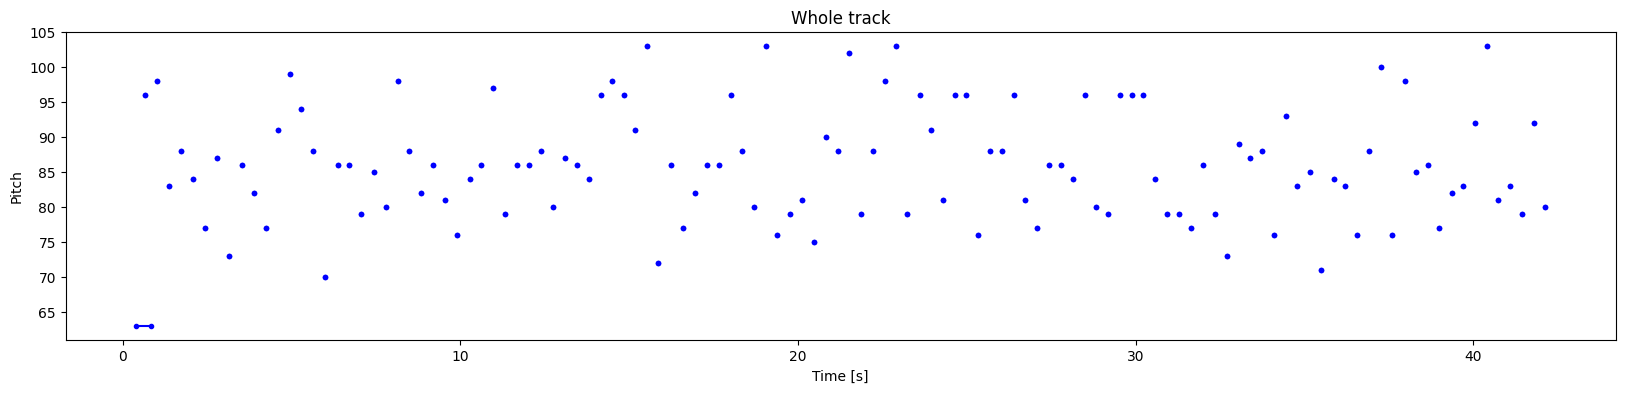

In [99]:
plot_piano_roll(generated_notes)

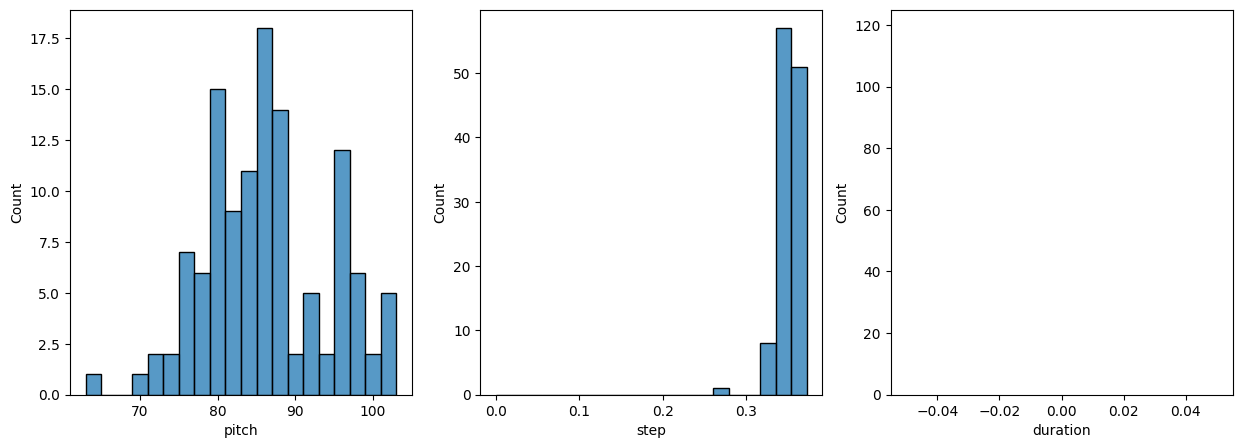

In [100]:
plot_distribution(generated_notes)